In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import random
from PIL import Image , ImageDraw
import torch
from torch import nn
from torchvision import transforms
from torchvision.transforms import functional as TF
import numpy as np
from torch.utils.data import Dataset , DataLoader
import torch.nn.functional as F
from torchsummary import summary
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch import optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torchvision
import copy

### **Data Exploration and Visualization**

In [3]:
label_data = pd.read_excel("/content/drive/MyDrive/01_Single_Object_Detection/Training400/Fovea_location.xlsx" , index_col = "ID")

In [4]:
label_data

,imgName,Fovea_X,Fovea_Y
ID,,,
1,A0001.jpg,1182.264278,1022.018842
2,A0002.jpg,967.754046,1016.946655
3,A0003.jpg,1220.206714,989.944033
4,A0004.jpg,1141.140888,1000.594955
5,A0005.jpg,1127.371832,1071.109440
...,...,...,...
396,N0307.jpg,823.024991,690.210211
397,N0308.jpg,647.598978,795.653188
398,N0309.jpg,624.571803,755.694880


In [5]:
label_data.tail()

,imgName,Fovea_X,Fovea_Y
ID,,,
396,N0307.jpg,823.024991,690.210211
397,N0308.jpg,647.598978,795.653188
398,N0309.jpg,624.571803,755.694880
399,N0310.jpg,687.523044,830.449187
400,N0311.jpg,746.107631,759.623062


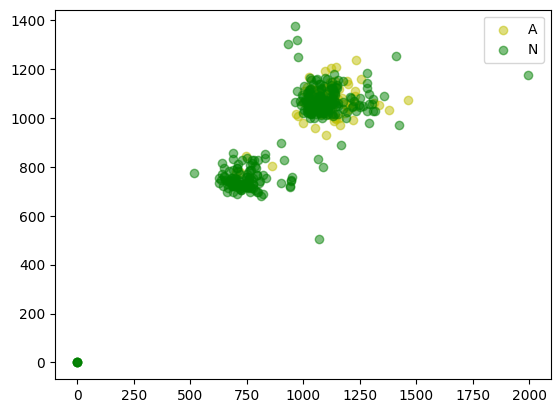

In [6]:
plt.scatter(label_data["Fovea_X"][ : 89] , label_data["Fovea_Y"][ 0 : 89] , c = "y" , alpha = 0.5)
plt.scatter(label_data["Fovea_X"][89 : ] , label_data["Fovea_Y"][89 :] , c = "g" , alpha = 0.5)
plt.legend(["A" , "N"])

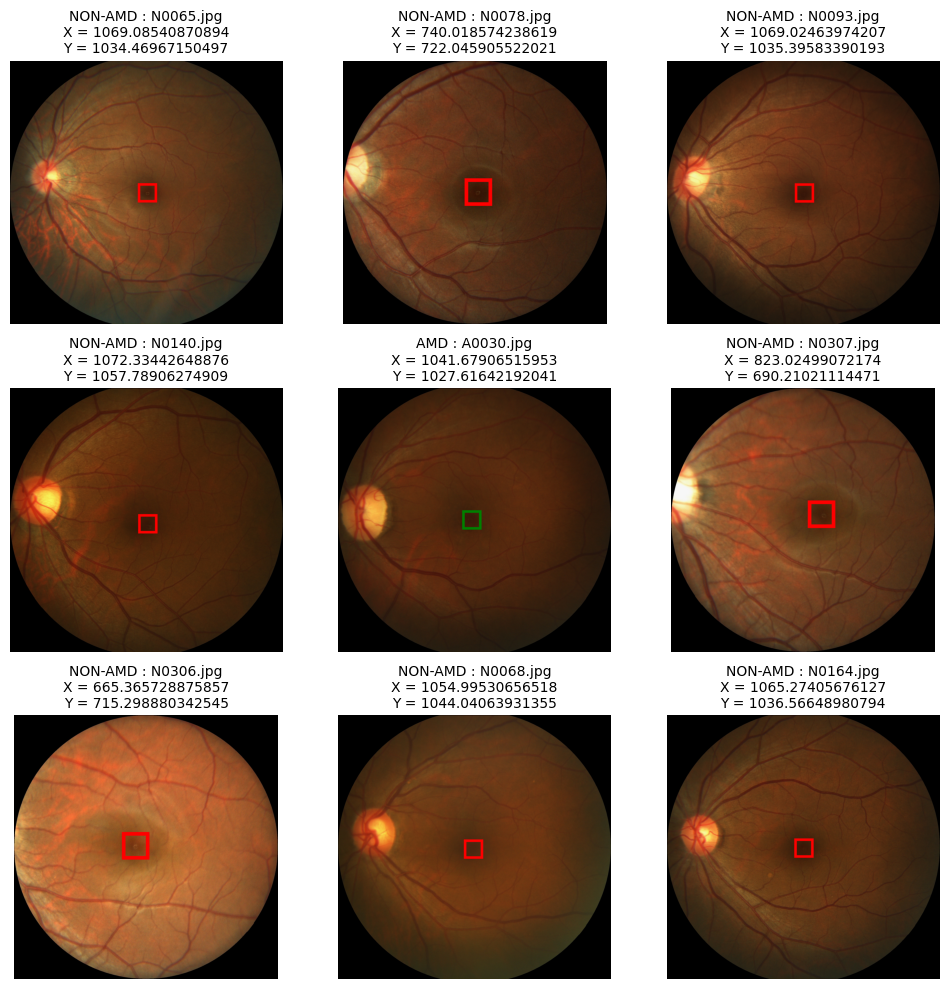

In [7]:
fig , ax = plt.subplots(figsize = (10 , 10) , ncols = 3 , nrows = 3)
for a in range(3):
  for b in range(3):
    classes = ["AMD" , "Non-AMD"]
    random_class = random.choice(classes)
    image_path = "/content/drive/MyDrive/01_Single_Object_Detection/Training400/" + random_class
    image = random.choice(os.listdir(image_path))
    i = 1
    for label in label_data["imgName"] :
      if image == label :
        x = label_data["Fovea_X"][i]
        y = label_data["Fovea_Y"][i]
        break
      i = i+1
    img = image_path + "/" + image
    img = Image.open(img)
    draw = ImageDraw.Draw(img)
    if random_class == "AMD" :
      color = "green"
    else :
      color = "red"
    draw.rectangle(((x-75, y-75), (x+75,y+75)),outline=color ,width=20)
    ax[a][b].imshow(img);
    ax[a][b].set_title(label = f"{random_class.upper()} : {image}\nX = {x}\nY = {y}" , fontsize = 10)
    ax[a][b].axis("off")

plt.tight_layout()

In [8]:
img.size

(2124, 2056)

### **Data Augmentation**

#### **Resize Images**

In [9]:

def resize_image(image , label , target_size = (256 , 256)) :
  w_org , h_org = image.size
  w_tar , h_tar = target_size
  resize = transforms.Resize(size = target_size)
  cx , cy = label
  new_label = cx/w_org*w_tar, cy/h_org*h_tar
  new_image = resize(image)
  return new_image , new_label

(128.3946132442962, 129.0666446453466)


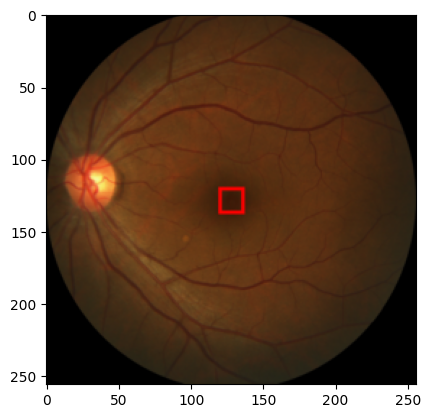

In [10]:
imgt = resize_image(image = img , label = (x , y))
plt.imshow(imgt[0]);
print(imgt[1])

In [11]:
def resize_img_label(image,label=(0.,0.),target_size=(256,256)):
  w_orig,h_orig = image.size
  w_target,h_target = target_size
  cx, cy= label

  image_new = TF.resize(image,target_size)
  label_new= cx/w_orig*w_target, cy/h_orig*h_target

  return image_new,label_new

In [12]:
def random_hflip(image,label):
  w,h=image.size
  x,y=label

  image = TF.hflip(image)
  label = w-x, y
  return image,label

In [13]:
def random_vflip(image,label):
  w,h=image.size
  x,y=label

  image = TF.vflip(image)
  label = x, h-y
  return image, label

In [14]:
def random_shift(image,label,max_translate=(0.2,0.2)):
  w,h=image.size
  max_t_w, max_t_h=max_translate
  cx, cy=label

  trans_coef=np.random.rand()*2-1
  w_t = int(trans_coef*max_t_w*w)
  h_t = int(trans_coef*max_t_h*h)

  image=TF.affine(image,translate=(w_t, h_t),shear=0,angle=0,scale=1)
  label = cx+w_t, cy+h_t

  return image,label

In [15]:
def scale_label(a,b):
    div = [ai/bi for ai,bi in zip(a,b)]
    return div

**In general probablies are set to 0.5 but here we are converting all the imageas and hence 1**


In [16]:
def transformer(image, label, params):
    image,label=resize_img_label(image,label,params["target_size"])

    if random.random() < params["p_hflip"]:
        image,label=random_hflip(image,label)

    if random.random() < params["p_vflip"]:
        image,label=random_vflip(image,label)

    if random.random() < params["p_shift"]:
        image,label=random_shift(image,label, params["max_translate"])

    if random.random() < params["p_brightness"]:
        brightness_factor=1+(np.random.rand()*2-1)*params["brightness_factor"]
        image=TF.adjust_brightness(image,brightness_factor)

    if random.random() < params["p_contrast"]:
        contrast_factor=1+(np.random.rand()*2-1)*params["contrast_factor"]
        image=TF.adjust_contrast(image,contrast_factor)

    if random.random() < params["p_gamma"]:
        gamma=1+(np.random.rand()*2-1)*params["gamma"]
        image=TF.adjust_gamma(image,gamma)

    if params["scale_label"]:
        label=scale_label(label,params["target_size"])

    image=TF.to_tensor(image)
    return image, label

In [17]:
param={
    "target_size" : (256, 256),
    "p_hflip" : 1.0,
    "p_vflip" : 1.0,
    "p_shift" : 1.0,
    "max_translate": (0.5, 0.5),
    "p_brightness": 1.0,
    "brightness_factor": 0.8,
    "p_contrast": 1.0,
    "contrast_factor": 0.8,
    "p_gamma": 1.0,
    "gamma": 0.4,
    "scale_label": False,
}

In [18]:
def drawing(img , x , y , width = 20) :
  draw = ImageDraw.Draw(img)
  draw.rectangle(((x-75, y-75), (x+75,y+75)),outline="green" ,width=width)

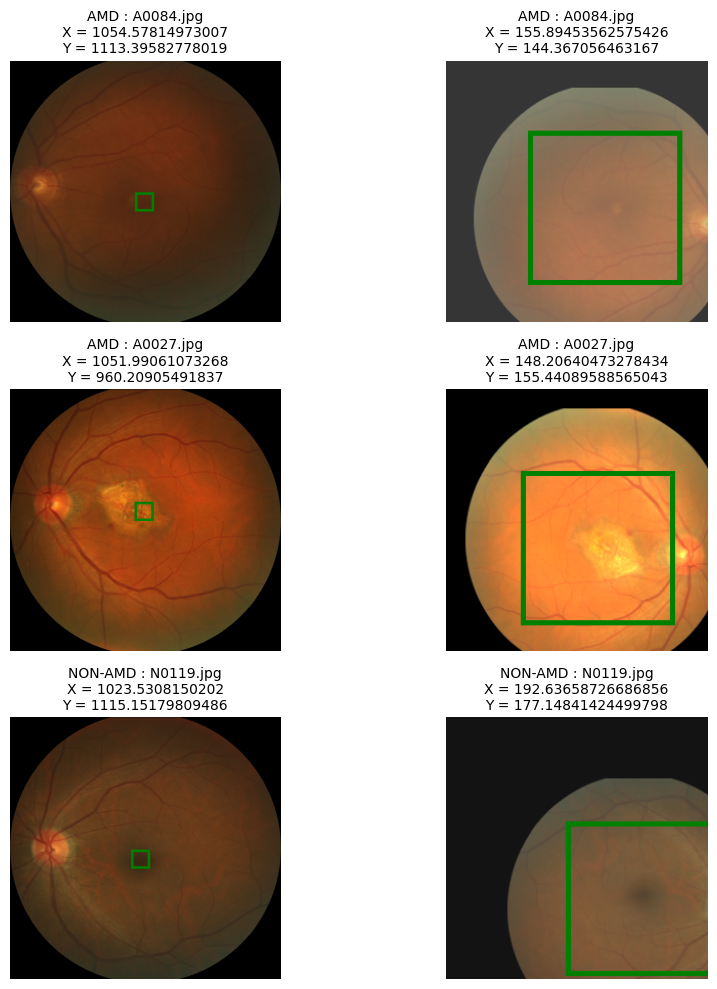

In [19]:
fig , ax = plt.subplots(figsize = (10 , 10) , ncols = 2 , nrows = 3)
for a in range(3):
  for b in range(1):
    classes = ["AMD" , "Non-AMD"]
    random_class = random.choice(classes)
    image_path = "/content/drive/MyDrive/01_Single_Object_Detection/Training400/" + random_class
    image = random.choice(os.listdir(image_path))
    i = 1
    for label in label_data["imgName"] :
      if image == label :
        x_org = label_data["Fovea_X"][i]
        y_org = label_data["Fovea_Y"][i]
        break
      i = i+1
    img = image_path + "/" + image
    img_org = Image.open(img)
    img_trans , label = transformer(image = img_org , label = (x_org , y_org) , params = param)
    img_trans = Image.fromarray((img_trans.permute(1 , 2 , 0).numpy() * 255).astype('uint8'))
    x_trans , y_trans = label
    drawing(img_org , x_org , y_org )
    drawing(img_trans , x_trans , y_trans , width = 5)

    ax[a][b].imshow(img_org);
    ax[a][b+1].imshow(img_trans)
    ax[a][b].set_title(label = f"{random_class.upper()} : {image}\nX = {x_org}\nY = {y_org}" , fontsize = 10)
    ax[a][b+1].set_title(label = f"{random_class.upper()} : {image}\nX = {x_trans}\nY = {y_trans}" , fontsize = 10)
    ax[a][b].axis("off")
    ax[a][b+1].axis("off")

plt.tight_layout()

### **NOTE : For Augmentation we have some online tools or libraries like :**
1. Augmenter: https://github.com/mdbloice/Augmentor
2. imgaug: https://github.com/aleju/imgaug
3. Albumentations: https://github.com/albu/albumentations

but the way I did i felt gave more flexiblity

### **We will be creating custom dataset and we could do the same using ImageFolder from Torchvision but due to labels it will be complex.**

In [20]:
path2data = "/content/drive/MyDrive/01_Single_Object_Detection/Training400/"

In [21]:
class AMD(Dataset) :
  def __init__(self , path2data , transform , trans_params) :
    path2labels = "/content/drive/MyDrive/01_Single_Object_Detection/Training400/Fovea_location.xlsx"

    labels_df=pd.read_excel(path2labels,index_col="ID")
    self.labels = labels_df[["Fovea_X","Fovea_Y"]].values

    self.imgName=labels_df["imgName"]
    self.ids=labels_df.index

    self.fullPath2img=[0]*len(self.ids)
    ## Gives 0 for lenght of Images

    for id_ in self.ids:
        if self.imgName[id_][0]=="A":
            prefix="AMD"
        else:
            prefix="Non-AMD"
        self.fullPath2img[id_-1]=os.path.join(path2data,prefix,self.imgName[id_])

    self.transform = transform
    self.trans_params=trans_params

  def __len__(self):
    return len(self.labels)

  def __getitem__(self, idx):
    image = Image.open(self.fullPath2img[idx])
    label = self.labels[idx]

    image,label = self.transform(image,label,self.trans_params)
    return image, label


In [22]:
trans_params_train={
    "target_size" : (256, 256),
    "p_hflip" : 0.5,
    "p_vflip" : 0.5,
    "p_shift" : 0.5,
    "max_translate": (0.2, 0.2),
    "p_brightness": 0.5,
    "brightness_factor": 0.2,
    "p_contrast": 0.5,
    "contrast_factor": 0.2,
    "p_gamma": 0.5,
    "gamma": 0.2,
    "scale_label": True,
}

trans_params_val={
    "target_size" : (256, 256),
    "p_hflip" : 0.0,
    "p_vflip" : 0.0,
    "p_shift" : 0.0,
    "p_brightness": 0.0,
    "p_contrast": 0.0,
    "p_gamma": 0.0,
    "gamma": 0.0,
    "scale_label": True,
}

### **NOTE : There is another transformation that we usually perform on the labels. In this transformation, we scale the labels to the range of [0, 1] in object it is good to perform this**

In [23]:
amd_ds1=AMD(path2data,transformer,trans_params_train)
amd_ds2=AMD(path2data,transformer,trans_params_val)

In [24]:
len(amd_ds1) , len(amd_ds2)

(400, 400)

### **NOTE: train_test_split is typically used for a single dataset, and in our case, we have two separate datasets (amd_ds1 and amd_ds2).**

In [25]:
from sklearn.model_selection import ShuffleSplit
sss = ShuffleSplit(n_splits=1, test_size=0.2, random_state=0)
indices=range(len(amd_ds1))


In [26]:
indices

range(0, 400)

In [27]:
from sklearn.model_selection import ShuffleSplit

sss = ShuffleSplit(n_splits=1, test_size=0.2, random_state=0)

indices=range(len(amd_ds1))

for train_index, val_index in sss.split(indices):
  print(len(train_index))
  print(len(val_index))

320
80


In [28]:
from torch.utils.data import Subset

train_ds=Subset(amd_ds1,train_index)
print(len(train_ds))

val_ds=Subset(amd_ds2,val_index)
print(len(val_ds))

320
80


If you want to split one PyTorch dataset into two training and validation
datasets using Subset or random_split from torch.utils.data,
define two objects of the dataset class. If you only define one instance of
the dataset class and create subset datasets by passing the difference
indices, they will get the same transformation function

In [29]:
print(train_ds)

In [30]:
def rescale_label(a,b):
  div = [ai*bi for ai,bi in zip(a,b)]
  return div

In [31]:
def show(img , label=None):
  timg = img.permute(1, 2 , 0).numpy()
  plt.imshow(timg)
  if label is not None:
      label=rescale_label(label,img.shape[1:])
      x,y=label
      plt.plot(x,y,'b+',markersize=20)

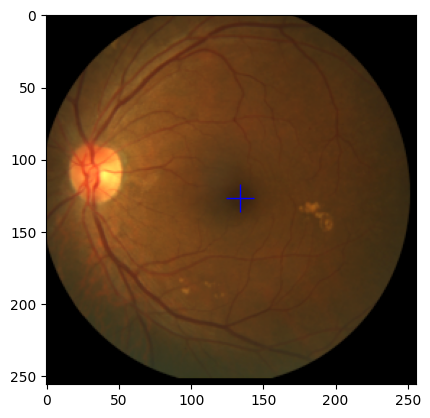

In [32]:
image , label = train_ds[random.choice(range(320))]
show(img = image , label = label)

In [33]:
train_dl = DataLoader(train_ds, batch_size=8, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=16, shuffle=False)

In [34]:
len(train_dl) , len(val_dl)

(40, 5)

### **Model Creation**

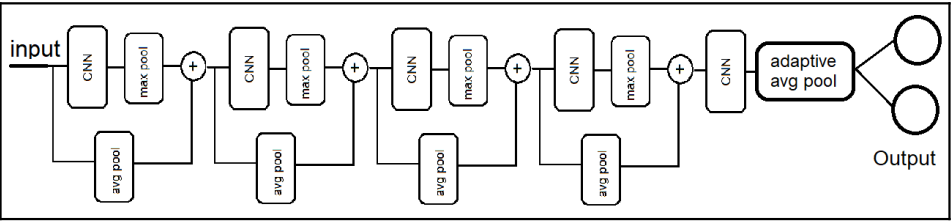

In [35]:
class Net(nn.Module):
   def __init__(self, params):
        super(Net, self).__init__()

   def forward(self, x):
        return x

def __init__(self, params):
    super(Net, self).__init__()

    C_in,H_in,W_in=params["input_shape"]
    init_f=params["initial_filters"]
    num_outputs=params["num_outputs"]

    self.conv1 = nn.Conv2d(C_in, init_f, kernel_size=3,stride=2,padding=1)
    self.conv2 = nn.Conv2d(init_f+C_in, 2*init_f, kernel_size=3,stride=1,padding=1)
    self.conv3 = nn.Conv2d(3*init_f+C_in, 4*init_f, kernel_size=3,padding=1)
    self.conv4 = nn.Conv2d(7*init_f+C_in, 8*init_f, kernel_size=3,padding=1)
    self.conv5 = nn.Conv2d(15*init_f+C_in, 16*init_f, kernel_size=3,padding=1)
    self.fc1 = nn.Linear(16*init_f, num_outputs)

def forward(self, x):
    identity=F.avg_pool2d(x,4,4)
    x = F.relu(self.conv1(x))
    x = F.max_pool2d(x, 2, 2)
    x = torch.cat((x, identity), dim=1)

    identity=F.avg_pool2d(x,2,2)
    x = F.relu(self.conv2(x))
    x = F.max_pool2d(x, 2, 2)
    x = torch.cat((x, identity), dim=1)

    identity=F.avg_pool2d(x,2,2)
    x = F.relu(self.conv3(x))
    x = F.max_pool2d(x, 2, 2)
    x = torch.cat((x, identity), dim=1)

    identity=F.avg_pool2d(x,2,2)
    x = F.relu(self.conv4(x))
    x = F.max_pool2d(x, 2, 2)
    x = torch.cat((x, identity), dim=1)

    x = F.relu(self.conv5(x))

    x=F.adaptive_avg_pool2d(x,1)
    x = x.reshape(x.size(0), -1)

    x = self.fc1(x)
    return x

def forward(self, x):
    identity=F.avg_pool2d(x,4,4)
    x = F.relu(self.conv1(x))
    x = F.max_pool2d(x, 2, 2)
    x = torch.cat((x, identity), dim=1)

    identity=F.avg_pool2d(x,2,2)
    x = F.relu(self.conv2(x))
    x = F.max_pool2d(x, 2, 2)
    x = torch.cat((x, identity), dim=1)

    identity=F.avg_pool2d(x,2,2)
    x = F.relu(self.conv3(x))
    x = F.max_pool2d(x, 2, 2)
    x = torch.cat((x, identity), dim=1)

    identity=F.avg_pool2d(x,2,2)
    x = F.relu(self.conv4(x))
    x = F.max_pool2d(x, 2, 2)
    x = torch.cat((x, identity), dim=1)

    x = F.relu(self.conv5(x))

    x=F.adaptive_avg_pool2d(x,1)
    x = x.reshape(x.size(0), -1)

    x = self.fc1(x)
    return x
Net.__init__=__init__
Net.forward=forward

* **identity = F.avg_pool2d(x, 2, 2)**: This line calculates the average pooling operation using the F.avg_pool2d function. It is applied to the input tensor x. The parameters are as follows:

* **x:** The input tensor on which the average pooling operation is performed.
2, 2: These numbers indicate the size of the pooling window. In this case, it's a 2x2 window. The window slides over the input and calculates the average value within the 2x2 region.
* **x = F.relu(self.conv2(x)):** After the average pooling operation, the code applies a convolution operation (self.conv2) to the input tensor x. The result of the convolution is then passed through the rectified linear unit (ReLU) activation function, denoted by F.relu.

* **x = F.max_pool2d(x, 2, 2):** Following the convolution and ReLU activation, the code applies max pooling using the F.max_pool2d function. It uses a 2x2 window for pooling, similar to the average pooling step.

* **x = torch.cat((x, identity), dim=1):** In this line, the code concatenates the results of max pooling (x) with the identity tensor that was created using average pooling. The torch.cat function concatenates tensors along a specified dimension (**dim=1 indicates concatenation along the channel dimension**). This operation combines the information from the max-pooled features and the average-pooled features.

In [36]:
params_model={
        "input_shape": (3,256,256),
        "initial_filters": 16,
        "num_outputs": 2
            }

model = Net(params_model)

In [37]:
print(model)

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv2): Conv2d(19, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(51, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(115, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(243, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=256, out_features=2, bias=True)
)


### **Defining Loss Function**
* The common loss functions for detection tasks are the mean square error (MSE) and
smoothed-L1 loss.
* Smooth-L1 Loss is less sensitive to outliers than the MSE and, in
some cases, prevents exploding gradients.

---

We will define a performance metric for our object detection called the Jaccard index,
or Intersection over Union (IOU).

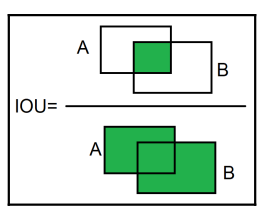

In [38]:
if torch.cuda.is_available():
  device = torch.device("cuda")
  model=model.to(device)
print(device)

cuda


## **MAKE IT A GENERAL PRACTICE AS THIS QUITE DIFFRENT WAY HOW I UNDERSTOOD EALIER**

In [39]:
loss_func = nn.SmoothL1Loss(reduction = "sum")

The reduction="sum" parameter specifies that the loss should be summed across all the elements in the batch.

**Testing Loss Funnction**

In [40]:
n = 8
c = 2
y = 0.5 * torch.ones(n , c , requires_grad = True)
print(y.shape)
target = torch.zeros(n, c, requires_grad=False)
print(target.shape)
loss = loss_func(y , target)
print(loss.item())

torch.Size([8, 2])
torch.Size([8, 2])
2.0


In [41]:
y = 2 * torch.ones(n, c, requires_grad=True)
target = torch.zeros(n, c, requires_grad=False)
loss = loss_func(y, target)
print(loss.item())

24.0


### **Here n is number of batches and c denotes output features**

In [42]:
opt = optim.Adam(model.parameters(), lr=3e-4)

**Testing Optimizer**

In [43]:
def get_lr(opt) :
  for param_group in opt.param_groups :
    return param_group["lr"]

**Each dictionary within param_groups typically contains the following key-value pairs:**

1. 'params': A list of model parameters (tensors) associated with this group. These are the parameters that will be updated during optimization.

2. 'lr': The learning rate (a scalar) for this parameter group. The learning rate controls the step size during gradient descent. Different parameter groups can have different learning rates, which allows you to fine-tune the optimization process.

3. 'weight_decay': A regularization term that encourages smaller parameter values. It's often used to prevent overfitting. This value is typically set to 0 for most parameter groups, but you can specify a different value for each group.

4. 'betas': A tuple of two values (β1, β2) for specific optimization algorithms like Adam. These values control the exponential moving averages of gradients and squared gradients. For many optimizers, this is optional.



In [44]:
current_lr = get_lr(opt = opt)
print(f"Current Learning Rate = {current_lr}")

Current Learning Rate = 0.0003


In [45]:
lr_scheduler = ReduceLROnPlateau(opt, mode='min',factor=0.5,
patience=20,verbose=1)

In [46]:
for i in range(100) :
  lr_scheduler.step(1)

Epoch 00022: reducing learning rate of group 0 to 1.5000e-04.
Epoch 00043: reducing learning rate of group 0 to 7.5000e-05.
Epoch 00064: reducing learning rate of group 0 to 3.7500e-05.
Epoch 00085: reducing learning rate of group 0 to 1.8750e-05.


### **Preparing IOU Function**

In [47]:
def cxcy2bbox(cxcy,w=50./256,h=50./256):
 w_tensor=torch.ones(cxcy.shape[0],1,device=cxcy.device)*w
 h_tensor=torch.ones(cxcy.shape[0],1,device=cxcy.device)*h
 cx=cxcy[:,0].unsqueeze(1)
 cy=cxcy[:,1].unsqueeze(1)
 boxes=torch.cat((cx,cy, w_tensor, h_tensor), -1) # cx,cy,w,h
 return torch.cat((boxes[:, :2] - boxes[:, 2:]/2, # xmin, ymin
 boxes[:, :2] + boxes[:, 2:]/2), 1) # xmax, ymax

In [48]:
cxcy=torch.rand(1,2)
print("center:", cxcy*256)
bb=cxcy2bbox(cxcy)
print("bounding box", bb*256)

center: tensor([[ 84.1212, 219.7316]])
bounding box tensor([[ 59.1212, 194.7316, 109.1212, 244.7316]])


###**Defining the metric(IOU)**

In [49]:
def metrics_batch(output, target):
 output=cxcy2bbox(output)
 target=cxcy2bbox(target)
 iou=torchvision.ops.box_iou(output, target)
 return torch.diagonal(iou, 0).sum().item()

In [50]:
n,c=8,2
target = torch.rand(n, c, device=device)
target=cxcy2bbox(target)
metrics_batch(target,target)


8.0

### **Defining Losss for Batch**

In [51]:
def loss_batch(loss_func, output, target, opt=None):
 loss = loss_func(output, target)
 with torch.no_grad():
  metric_b = metrics_batch(output,target)
  if opt is not None:
    opt.zero_grad()
    loss.backward()
    opt.step()
 return loss.item(), metric_b


In [52]:
image , label = next(iter(train_dl))

In [53]:
label

[tensor([0.6431, 0.5411, 0.5522, 0.4993, 0.5700, 0.5270, 0.5427, 0.5283],
        dtype=torch.float64),
 tensor([0.4637, 0.5063, 0.4818, 0.5062, 0.5220, 0.4997, 0.5618, 0.5860],
        dtype=torch.float64)]

In [54]:
for xb,label_b in train_dl:
  label_b=torch.stack(label_b,1)
  label_b=label_b.type(torch.float32)
  label_b=label_b.to(device)

  l,m=loss_batch(loss_func,label_b,label_b)
  print(l,m)
  break

0.0 8.0


### **Training and Evaluating Model**

In [55]:
def loss_epoch(model,loss_func,dataset_dl,sanity_check=False,opt=None):
  running_loss=0.0
  running_metric=0.0
  len_data=len(dataset_dl.dataset)

  for xb, yb in dataset_dl:
    yb=torch.stack(yb,1)
    yb=yb.type(torch.float32).to(device)

    output=model(xb.to(device))

    loss_b,metric_b=loss_batch(loss_func, output, yb, opt)

    running_loss+=loss_b

    if metric_b is not None:
      running_metric+=metric_b

  loss=running_loss/float(len_data)

  metric=running_metric/float(len_data)

  return loss, metric


In [56]:
def train_val(model, params):
  num_epochs=params["num_epochs"]
  loss_func=params["loss_func"]
  opt=params["optimizer"]
  train_dl=params["train_dl"]
  val_dl=params["val_dl"]
  sanity_check=params["sanity_check"]
  lr_scheduler=params["lr_scheduler"]
  path2weights=params["path2weights"]

  loss_history={
      "train": [],
      "val": [],
  }

  metric_history={
      "train": [],
      "val": [],
  }

  best_model_wts = copy.deepcopy(model.state_dict())

  best_loss=float('inf')

  for epoch in range(num_epochs):
    current_lr=get_lr(opt)
    print('Epoch {}/{}, current lr={}'.format(epoch, num_epochs - 1, current_lr))

    model.train()
    train_loss, train_metric=loss_epoch(model,loss_func,train_dl,sanity_check,opt)

    loss_history["train"].append(train_loss)
    metric_history["train"].append(train_metric)

    model.eval()
    with torch.no_grad():
        val_loss, val_metric=loss_epoch(model,loss_func,val_dl,sanity_check)

    loss_history["val"].append(val_loss)
    metric_history["val"].append(val_metric)

    if val_loss < best_loss:
        best_loss = val_loss
        best_model_wts = copy.deepcopy(model.state_dict())

        torch.save(model.state_dict(), path2weights)
        print("Copied best model weights!")

    lr_scheduler.step(val_loss)
    if current_lr != get_lr(opt):
        print("Loading best model weights!")
        model.load_state_dict(best_model_wts)

    print("train loss: %.6f, accuracy: %.2f" %(train_loss,100*train_metric))
    print("val loss: %.6f, accuracy: %.2f" %(val_loss,100*val_metric))
    print("-"*10)

  model.load_state_dict(best_model_wts)
  return model, loss_history, metric_history

In [59]:
loss_func=nn.SmoothL1Loss(reduction="sum")
opt = optim.Adam(model.parameters(), lr=1e-4)
lr_scheduler = ReduceLROnPlateau(opt, mode='min',factor=0.5, patience=20,verbose=1)

path2models= "./models/"
if not os.path.exists(path2models):
        os.mkdir(path2models)

params_train={
    "num_epochs": 100,
    "optimizer": opt,
    "loss_func": loss_func,
    "train_dl": train_dl,
    "val_dl": val_dl,
    "sanity_check": False,
    "lr_scheduler": lr_scheduler,
    "path2weights": path2models+"weights_smoothl1.pt",
}

# train and validate the model
model,loss_hist,metric_hist=train_val(model,params_train)

Epoch 0/99, current lr=0.0001
Copied best model weights!
train loss: 0.006629, accuracy: 41.18
val loss: 0.010456, accuracy: 37.87
----------
Epoch 1/99, current lr=0.0001
Copied best model weights!
train loss: 0.005653, accuracy: 48.68
val loss: 0.010154, accuracy: 53.63
----------
Epoch 2/99, current lr=0.0001
train loss: 0.005455, accuracy: 48.77
val loss: 0.010848, accuracy: 39.01
----------
Epoch 3/99, current lr=0.0001
Copied best model weights!
train loss: 0.006123, accuracy: 45.63
val loss: 0.009749, accuracy: 61.44
----------
Epoch 4/99, current lr=0.0001
train loss: 0.005115, accuracy: 49.25
val loss: 0.009869, accuracy: 47.86
----------
Epoch 5/99, current lr=0.0001
train loss: 0.005691, accuracy: 46.51
val loss: 0.009890, accuracy: 52.16
----------
Epoch 6/99, current lr=0.0001
train loss: 0.005244, accuracy: 47.90
val loss: 0.009965, accuracy: 53.17
----------
Epoch 7/99, current lr=0.0001
train loss: 0.004981, accuracy: 50.16
val loss: 0.010081, accuracy: 57.63
----------

Text(0, 0.5, 'Loss')

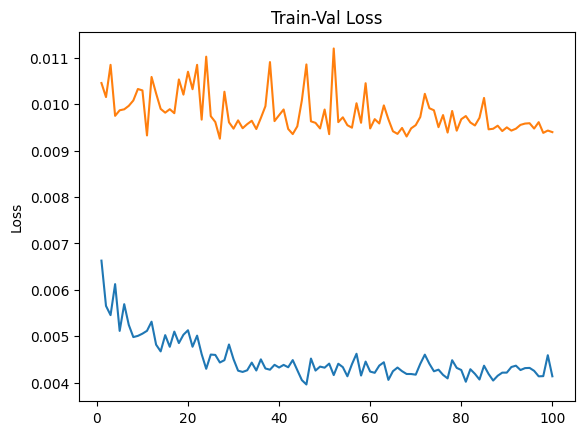

In [61]:
num_epochs=params_train["num_epochs"]
plt.title("Train-Val Loss")
plt.plot(range(1,num_epochs+1),loss_hist["train"],label="train")
plt.plot(range(1,num_epochs+1),loss_hist["val"],label="val")
plt.ylabel("Loss")

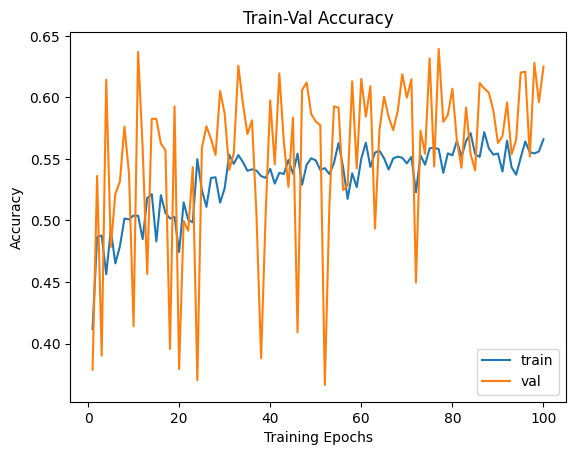

In [60]:
# plot accuracy progress
plt.title("Train-Val Accuracy")
plt.plot(range(1,num_epochs+1),metric_hist["train"],label="train")
plt.plot(range(1,num_epochs+1),metric_hist["val"],label="val")
plt.ylabel("Accuracy")
plt.xlabel("Training Epochs")
plt.legend()
plt.show()
